# Advanced Lane Finding
------------

## 1. Camera Calibration

This section uses some images of a chessboard pattern to calibrate the used camera.

In [1]:
%matplotlib inline
import os
import cv2
import glob
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

# Get calibration image paths
img_paths = glob.glob("./camera_cal/calibration*.jpg")

# Size of the calibration pattern
chess_width = 9
chess_height = 6

objpoints = [] # undistorted world points
imgpoints = [] # distorted image points

objp = np.zeros((chess_width * chess_height, 3), np.float32)
objp[:,:2] = np.mgrid[0:chess_width,0:chess_height].T.reshape(-1,2)

for path in img_paths:
    img = mpimg.imread(path)
    
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    ret, corners = cv2.findChessboardCorners(gray, (chess_width, chess_height), None)
    
    if ret:
        imgpoints.append(corners)
        objpoints.append(objp)
        
        img = cv2.drawChessboardCorners(img, (chess_width, chess_height), corners, ret)
        #plt.imshow(img)
    else:
        print("Couldn't find all corners in image:", path)

Couldn't find all corners in image: ./camera_cal/calibration4.jpg
Couldn't find all corners in image: ./camera_cal/calibration5.jpg
Couldn't find all corners in image: ./camera_cal/calibration1.jpg


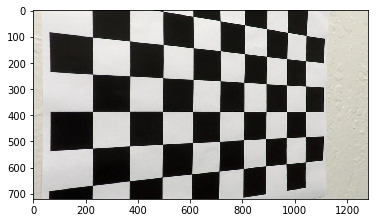

In [2]:
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape, None, None)

test_img = mpimg.imread("./camera_cal/calibration5.jpg")

undistorted = cv2.undistort(test_img, mtx, dist, None)

plt.imshow(undistorted)

## 2. Binarize Image

This section defines defines the pipeline to binarize the input images to find the left and right lane line.

In [3]:
# Define some useful help functions first

def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):

    sobel = np.zeros_like(img)
    if orient == 'x':
        sobel = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    elif orient == 'y':
        sobel = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    else:
        raise "Orientation has to be x or y"

    abs_sobel = np.absolute(sobel)
    scaled_sobel = (255*abs_sobel/np.max(abs_sobel))
    
    binary = np.zeros_like(scaled_sobel)
    binary[(scaled_sobel > thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    
    return binary

def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):

    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    magnitude = np.sqrt(sobelx**2 + sobely**2)
    binary = np.zeros_like(img)
    binary[(magnitude > mag_thresh[0]) & (magnitude <= mag_thresh[1])] = 1

    return binary

def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):

    sobelx = np.absolute(cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    sobely = np.absolute(cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
    magnitude_angle = np.arctan2(sobely, sobelx)
    binary = np.zeros_like(gray)
    binary[(magnitude_angle > thresh[0]) & (magnitude_angle <= thresh[1])] = 1

    return binary

def clrspc_threshold(img, colorspace='hls', channel='s', thresh=(0, 255)):
    
    conv_img = np.zeros_like(img)

    h, s, v_l = None, None, None
    
    if colorspace == 'hls':    
        conv_img = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        h = conv_img[:,:,0]
        v_l = conv_img[:,:,1]
        s = conv_img[:,:,2]
    elif colorspace == 'hsv':    
        conv_img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        h = conv_img[:,:,0]
        s = conv_img[:,:,1]
        v_l = conv_img[:,:,2]
    else:
        raise 'Colorspace has to be hsv or hls'

    ret = np.zeros_like(h)

    if channel == 'h':
        ret[(h > thresh[0]) & (h <= thresh[1])] = 1
    elif channel == 's':
        ret[(s > thresh[0]) & (s <= thresh[1])] = 1
    elif (channel == 'v') | (channel == 'l'):
        ret[(v_l > thresh[0]) & (v_l <= thresh[1])] = 1
    else:
        raise 'Channel has to be h, s, v or l'
    
    return ret

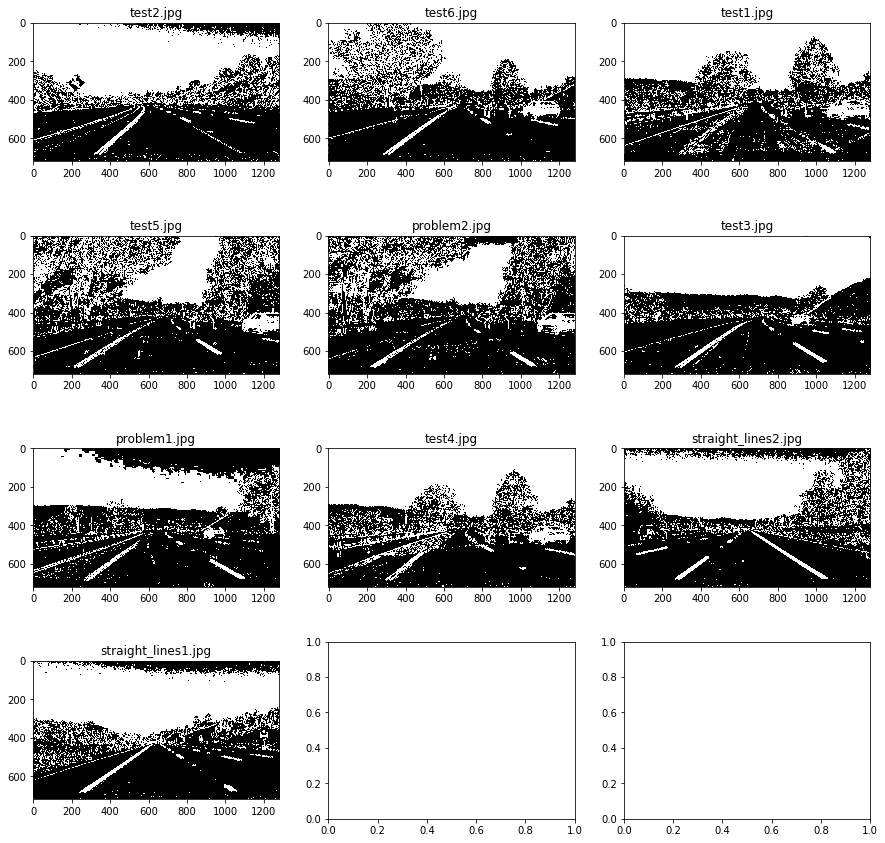

In [4]:
def binarize_image(img):
    
    hsv_v = clrspc_threshold(img, colorspace='hsv', channel='v', thresh=(210, 255))
    ang_v = dir_threshold(hsv_v, sobel_kernel=9, thresh=(0.7, 1.3))

    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    gray_sobx = abs_sobel_thresh(gray, orient='x', sobel_kernel=9, thresh=(15, 255))

    blue = np.zeros_like(gray)
    blue[(img[:,:,2] > 180)] = 1

    ret = np.zeros_like(gray)
    ret[((gray_sobx==1) | (blue==1)) | (ang_v==1)] = 1

    return ret

test_image_path = "./test_images"
test_images = os.listdir(test_image_path)
figs, axes = plt.subplots(nrows=int(np.ceil(len(test_images)/3)), ncols=3, figsize=(15,int(np.ceil(len(test_images)*1.5))))
for ax, img_path in zip(axes.ravel(), test_images):
    img = mpimg.imread(os.path.join(test_image_path, img_path))
    ax.imshow(binarize_image(img), cmap='gray')
    ax.set_title(img_path)

## 3. Transform Image

This section transforms the binarized image to bird view.

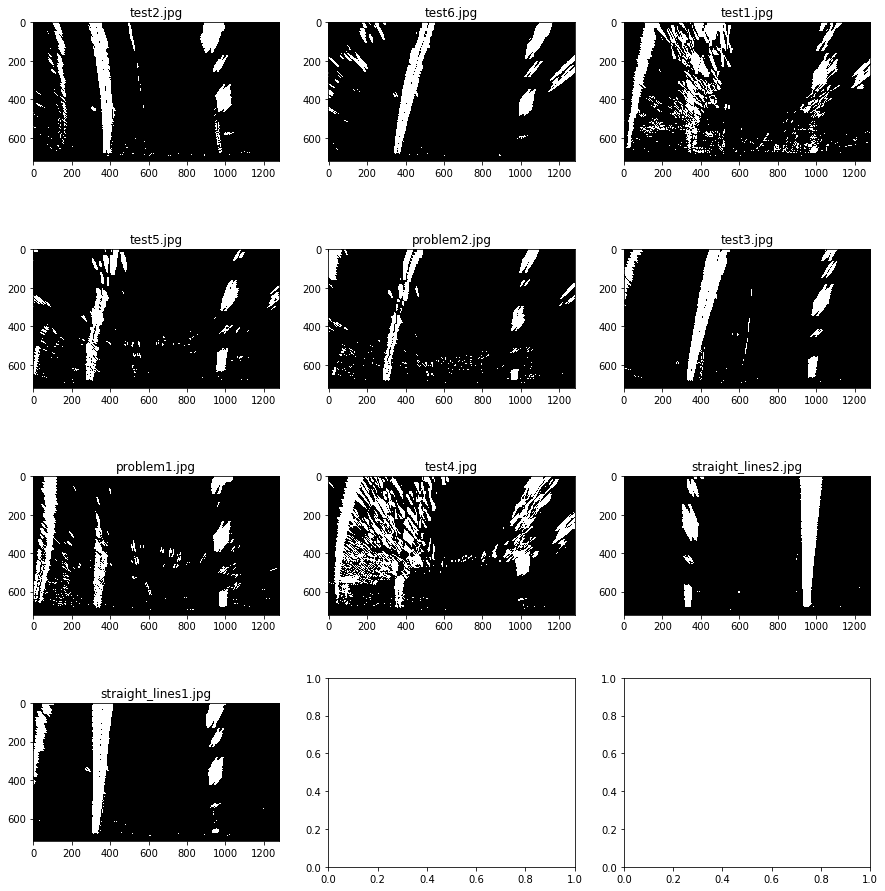

In [5]:
import os

ppm = (1055-269)/3.7
width = int(3 * ppm)

vert_in = np.array([[269, 675],
                    [1055, 675],
                    [873, 564],
                    [426, 564]], np.float32)
vert_out = np.array([[int((1280-width)/2), 675],
                     [int((1280+width)/2), 675],
                     [int((1280+width)/2), 675-int(0.5*ppm)],
                     [int((1280-width)/2), 675-int(0.5*ppm)]], np.float32)

ret = cv2.cvtColor(mpimg.imread("test_images/straight_lines1.jpg"), cv2.COLOR_RGB2GRAY)

M = cv2.getPerspectiveTransform(vert_in, vert_out)
Minv = cv2.getPerspectiveTransform(vert_out, vert_in)

test_image_path = "./test_images"
test_images = os.listdir(test_image_path)
figs, axes = plt.subplots(nrows=int(np.ceil(len(test_images)/3)), ncols=3, figsize=(15,int(np.ceil(len(test_images)/3)*4)))
for ax, img_path in zip(axes.ravel(), test_images):
    img = mpimg.imread(os.path.join(test_image_path, img_path))
    #img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    img = binarize_image(img)
    img = cv2.warpPerspective(img, M, img.shape[::-1], flags=cv2.INTER_LINEAR)
    ax.imshow(img, cmap='gray')
    ax.set_title(img_path)

## 4. Fit Polynomial

This section detects the pixels belonging to left and right lane line and fits a quadratic polynomial in it.

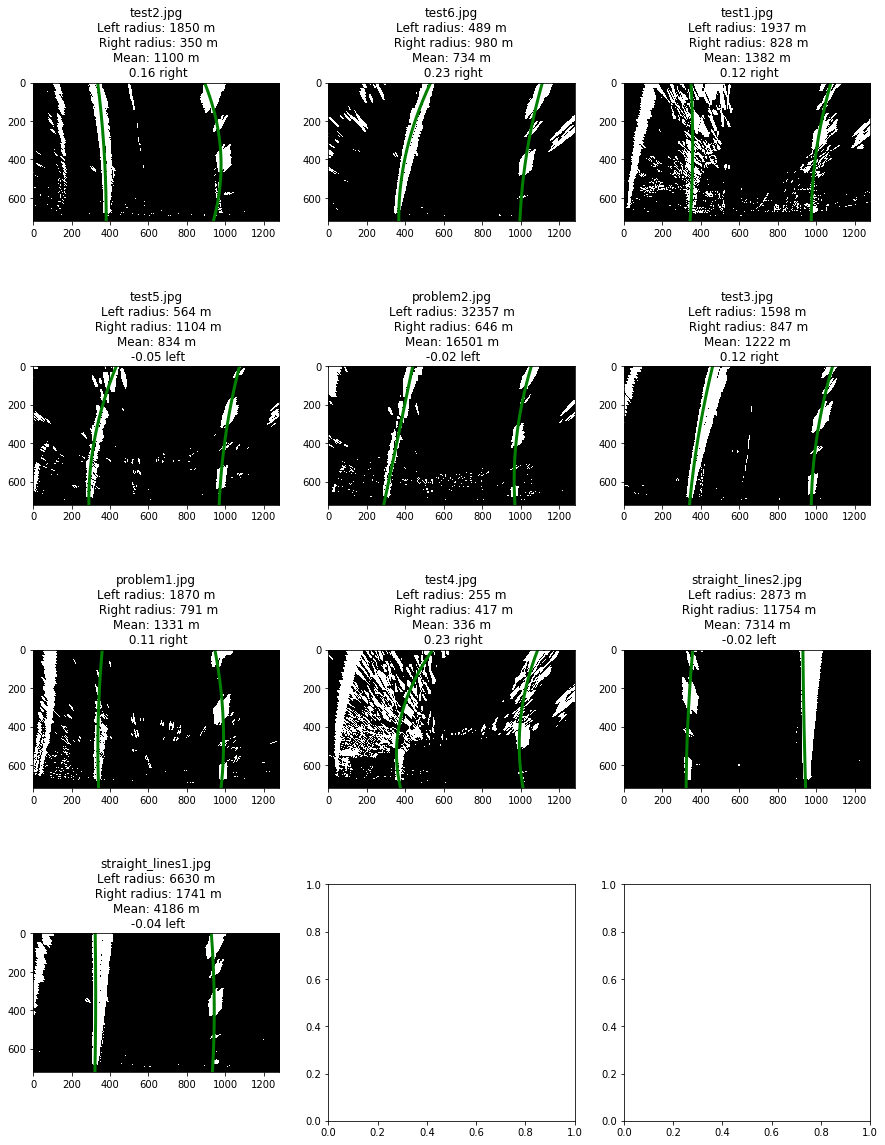

In [6]:
def window_mask(width, height, img_ref, center,level):
    output = np.zeros_like(img_ref)
    output[int(img_ref.shape[0]-(level+1)*height):int(img_ref.shape[0]-level*height),\
           max(0,int(center-width/2)):min(int(center+width/2),img_ref.shape[1])] = 1
    return output

def find_window_centroids(image, window_width, window_height, margin):
    
    window_centroids = [] # Store the (left,right) window centroid positions per level
    window = np.ones(window_width) # Create our window template that we will use for convolutions
    
    # First find the two starting positions for the left and right lane by using np.sum to get the vertical image slice
    # and then np.convolve the vertical image slice with the window template 
    
    # Sum quarter bottom of image to get slice, could use a different ratio
    l_sum = np.sum(image[int(3*image.shape[0]/4):,int(image.shape[1]/5):int(image.shape[1]/2)], axis=0)
    l_center = np.argmax(np.convolve(window,l_sum))-window_width/2+int(image.shape[1]/5)
    r_sum = np.sum(image[int(3*image.shape[0]/4):,int(image.shape[1]/2):int(4*image.shape[1]/5)], axis=0)
    r_center = np.argmax(np.convolve(window,r_sum))-window_width/2+int(image.shape[1]/2)
    
    # Add what we found for the first layer
    window_centroids.append((l_center,r_center))
    
    # Go through each layer looking for max pixel locations
    for level in range(1,(int)(image.shape[0]/window_height)):
        # convolve the window into the vertical slice of the image
        image_layer = np.sum(image[int(image.shape[0]-(level+1)*window_height):int(image.shape[0]-level*window_height),:], axis=0)
        conv_signal = np.convolve(window, image_layer)
        # Find the best left centroid by using past left center as a reference
        # Use window_width/2 as offset because convolution signal reference is at right side of window, not center of window
        offset = window_width/2
        l_min_index = int(max(l_center+offset-margin,0))
        l_max_index = int(min(l_center+offset+margin,image.shape[1]))
        l_center = np.argmax(conv_signal[l_min_index:l_max_index])+l_min_index-offset
        # Find the best right centroid by using past right center as a reference
        r_min_index = int(max(r_center+offset-margin,0))
        r_max_index = int(min(r_center+offset+margin,image.shape[1]))
        r_center = np.argmax(conv_signal[r_min_index:r_max_index])+r_min_index-offset
        # Add what we found for that layer
        window_centroids.append((l_center,r_center))

    return window_centroids

def filter_lane_pixels(img, centroids, window_width, window_height):
    
    l_points = np.zeros_like(img)
    r_points = np.zeros_like(img)    
    
    if(len(centroids) > 0):
        for level in range(0,len(centroids)):
            # Window_mask is a function to draw window areas
            l_mask = window_mask(window_width,window_height,img,centroids[level][0],level)
            r_mask = window_mask(window_width,window_height,img,centroids[level][1],level)
            # Add graphic points from window mask here to total pixels found 
            l_points[(l_points == 255) | ((l_mask == 1) ) ] = 255
            r_points[(r_points == 255) | ((r_mask == 1) ) ] = 255
    
    return l_points, r_points

def quadratic_fit(l_points, r_points, img_height=720, conversion=(1.0,1.0)):
    left_x, left_y = np.where(l_points == 255)
    right_x, right_y = np.where(r_points == 255)
    
    left_coeff, right_coeff = [], []
    y = np.arange(img_height, dtype=np.float32)

    if len(left_x > 0):
        left_coeff = np.polyfit(left_x*conversion[0], left_y*conversion[1], 2)

    if len(right_x > 0):
        right_coeff = np.polyfit(right_x*conversion[0], right_y*conversion[1], 2)
    
    return left_coeff, right_coeff
    
def get_fitted_lines(coeffs, img_height=720):
    
    left_coeffs = coeffs[0]
    right_coeffs = coeffs[1]
    
    y = np.arange(img_height)

    l_x = left_coeffs[0]*y**2 + left_coeffs[1]*y + left_coeffs[2]
    r_x = right_coeffs[0]*y**2 + right_coeffs[1]*y + right_coeffs[2]
    
    return l_x, r_x
    
def get_radius(coeffs, y=720, conversion=(1.0,1.0)):
    
    left_coeffs = coeffs[0]
    right_coeffs = coeffs[1]
    
    l_r, r_r = 0, 0

    l_r = ((1 + (2*left_coeffs[0]*y*conversion[1] + left_coeffs[1])**2)**(3/2)) / np.absolute(2*left_coeffs[0])
    r_r = ((1 + (2*right_coeffs[0]*y*conversion[1] + right_coeffs[1])**2)**(3/2)) / np.absolute(2*right_coeffs[0])
        
    return l_r, r_r
    
figs, axes = plt.subplots(nrows=int(np.ceil(len(test_images)/3)), ncols=3, figsize=(15,int(np.ceil(len(test_images)/3)*5)))
for ax, img_path in zip(axes.ravel(), test_images):
    y_ppm = 30/720
    x_ppm = 3.7/700
    img = mpimg.imread(os.path.join(test_image_path, img_path))
    img = binarize_image(img)
    img = cv2.warpPerspective(img, M, img.shape[::-1], flags=cv2.INTER_LINEAR)
    window_centroids = find_window_centroids(img, 30, 80, 50)
    l_points, r_points = filter_lane_pixels(img, window_centroids, 30, 80)
    l_coeffs, r_coeffs = quadratic_fit(l_points, r_points)
    l_x, r_x = get_fitted_lines((l_coeffs, r_coeffs))
    p_y = np.arange(720)
    
    ax.imshow(img, cmap='gray')
    ax.set_xlim(0, 1280)
    ax.set_ylim(0, 720)
    ax.plot(l_x, p_y, color='green', linewidth=3)
    ax.plot(r_x, p_y, color='green', linewidth=3)
    ax.invert_yaxis()
    
    l_coeffs, r_coeffs = quadratic_fit(l_points, r_points,conversion=(y_ppm,x_ppm))
    l_r, r_r = get_radius((l_coeffs, r_coeffs), conversion=(y_ppm,x_ppm))
    
    eccentricity = (window_centroids[0][1] + window_centroids[0][0])/2 - 1280/2
    eccentricity *= x_ppm
    side = "right" if eccentricity > 0 else "left"
    
    ax.set_title("{}\nLeft radius: {} m\n Right radius: {} m\nMean: {} m\n {:.2f} {}".format(\
                img_path, int(l_r), int(r_r), int((l_r+r_r)/2), eccentricity, side))

## 5. Final Pipeline

This section combines all prior steps and deploys them on a example video.

In [7]:
class Line():
    def __init__(self):
        # x values of the last n fits of the line [px]
        self.recent_xfitted = [] 
        # average x values of the fitted line over the last n iterations [px]
        self.bestx = None     
        # radii of the last n fits
        self.recent_radii = [] 
        # average radius of the last n fits
        self.best_radius= None

/home/rainer/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel/__main__.py:100: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


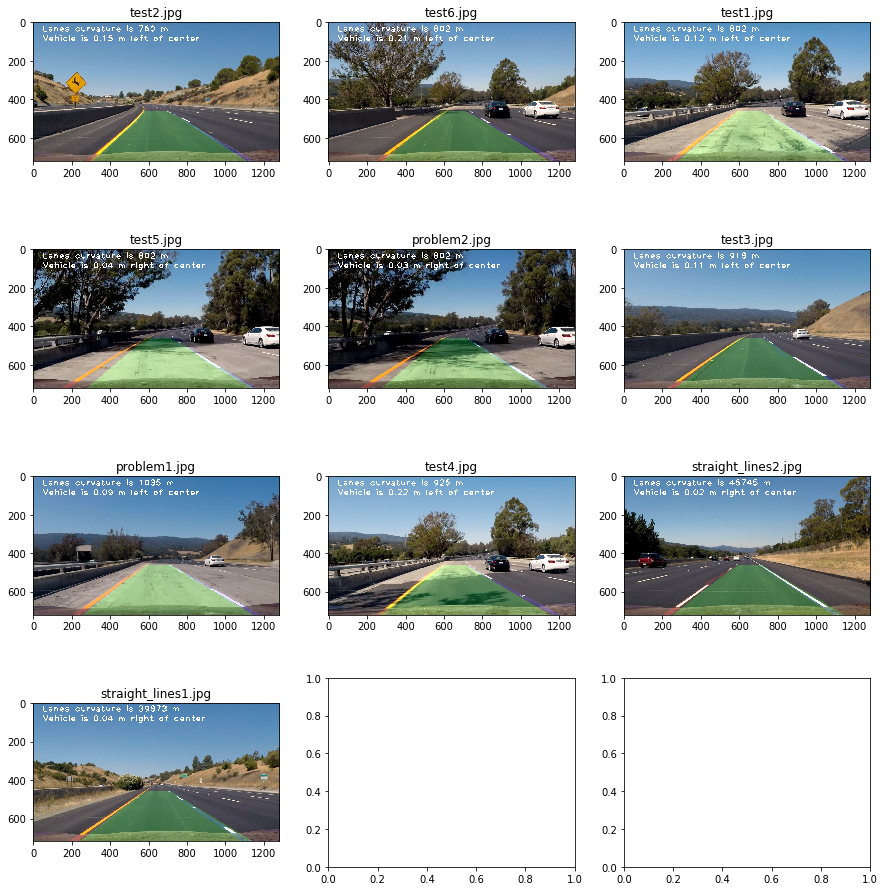

In [8]:
y_ppm = 30/720
x_ppm = 3.7/700
avg_cnt = 7
not_valid_cnt = 0

window_size = (30, 80)

left_line = Line()
right_line = Line()

def process(input_img):
    
    global not_valid_cnt
    
    # Undistort image
    undistorted = cv2.undistort(input_img, mtx, dist, None)
    
    out = undistorted
    
    # Create binary image
    binary = binarize_image(undistorted)
    
    # warp image into bird view
    warped = cv2.warpPerspective(binary, M, binary.shape[::-1], flags=cv2.INTER_LINEAR)
    
    # find centroids of the seeking windows
    centroids = find_window_centroids(warped, window_size[0], window_size[1], 50)
    
    # seperate lane lines in warped binary image with the found centroids
    l_points, r_points = filter_lane_pixels(warped, centroids, window_size[0], window_size[1])
    
    # get the coefficients of the quadratic fit in pixel space
    l_coeffs, r_coeffs = quadratic_fit(l_points, r_points)
    
    # get the coefficients of the quadratic fit in metric space
    l_coeffs_m, r_coeffs_m = quadratic_fit(l_points, r_points, conversion=(y_ppm, x_ppm))
    
    # get the found lane lines with one pixel per y-value
    l_x, r_x = get_fitted_lines((l_coeffs, r_coeffs))

    # get the curvature of the current lane lines
    l_r, r_r = get_radius((l_coeffs_m, r_coeffs_m), conversion=(y_ppm,x_ppm))
    
    # check validity of the last fit by thresholding the lane width
    data_valid = True   
    lane_width = (r_x-l_x)*x_ppm
    if(np.any(lane_width < 2.5) | (np.any(lane_width > 3.5))):
        data_valid = False
    
    # if data is valid continue with processing
    if(data_valid | (not_valid_cnt >= 5)):
        
        not_valid_cnt = 0
        
        # process left line
        
        # store the last valid fitted x values for the left line and calculate the average values
        if len(left_line.recent_xfitted) >= avg_cnt:
            left_line.recent_xfitted.pop(0)
        
        left_line.recent_xfitted.append(l_x)
        
        left_line.bestx = np.average(left_line.recent_xfitted, axis=0)     
        
        # store the last valid fitted radii for the left line and calculate the average value
        if len(left_line.recent_radii) >= avg_cnt:
            left_line.recent_radii.pop(0)
            
        left_line.recent_radii.append(l_r)

        left_line.best_radius= np.average(left_line.recent_radii, axis=0)
        
        # process right line
        
         # store the last valid fitted x values for the right line and calculate the average values  
        if len(right_line.recent_xfitted) >= avg_cnt:
            right_line.recent_xfitted.pop(0)
        
        right_line.recent_xfitted.append(r_x)
        
        right_line.bestx = np.average(right_line.recent_xfitted, axis=0)     
    
        # store the last valid fitted radii for the right line and calculate the average value
        if len(right_line.recent_radii) >= avg_cnt:
            right_line.recent_radii.pop(0)
            
        right_line.recent_radii.append(r_r)

        right_line.best_radius = np.average(right_line.recent_radii, axis=0)
    else:
        not_valid_cnt += 1
    
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    p_y = np.arange(img.shape[0])
    
    # start drawing if there are valid values
    if (left_line.bestx != None) and (right_line.bestx != None):
        
        # Recast the x and y points into usable format for cv2.fillPoly()
        pts_left = np.array([np.transpose(np.vstack([left_line.bestx, p_y]))])
        pts_right = np.array([np.flipud(np.transpose(np.vstack([right_line.bestx, p_y])))])
        pts = np.hstack((pts_left, pts_right))
        
        # calculate the mean between left and right line radius
        mean_curvature = int((left_line.best_radius+right_line.best_radius)/2)
        
        # calculate the eccentricity of the lane center
        eccentricity = (centroids[0][1] + centroids[0][0])/2 - input_img.shape[1]/2
        eccentricity *= x_ppm
        side = "left" if eccentricity > 0 else "right"
        
        # Draw the lane onto the warped blank image
        cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

        color_warp[:,:,0] = l_points
        color_warp[:,:,2] = r_points

        # warp the blank back to original image space using inverse perspective matrix (Minv)
        newwarp = cv2.warpPerspective(color_warp, Minv, (input_img.shape[1], input_img.shape[0]))
        out = cv2.addWeighted(input_img, 1, newwarp, 0.2, 0)
        
        # write text on image
        cv2.putText(out, "Lanes curvature is {} m".format(mean_curvature),\
                    (50,50), cv2.FONT_HERSHEY_PLAIN, 3, (255,255,255), thickness=3)
        cv2.putText(out, "Vehicle is {:.2f} m {} of center".format(np.absolute(eccentricity), side),\
                    (50,100), cv2.FONT_HERSHEY_PLAIN, 3, (255,255,255), thickness=3)
    return out

figs, axes = plt.subplots(nrows=int(np.ceil(len(test_images)/3)), ncols=3, figsize=(15,int(np.ceil(len(test_images)/3)*4)))
for ax, img_path in zip(axes.ravel(), test_images):
    img = mpimg.imread(os.path.join(test_image_path, img_path))
    out = process(img)
    ax.imshow(out)
    mpimg.imsave(os.path.join("./output_images", img_path), out, format="jpg")
    ax.set_title(img_path)

In [9]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML
video_output = 'out.mp4'
clip_in = VideoFileClip("project_video.mp4")
clip_out = clip_in.fl_image(process)
%time clip_out.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video out.mp4
[MoviePy] Writing video out.mp4


100%|█████████▉| 1260/1261 [04:52<00:00,  4.32it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: out.mp4 

CPU times: user 6min 35s, sys: 6.31 s, total: 6min 41s
Wall time: 4min 53s
